In [42]:
# Welcome to Huichen's code broken down to understand how to use different functions in SKLEARN
# the documentation for sk learn can be found at this link. http://scikit-learn.org/stable/documentation.html


In [5]:
# First step is to import some packages. 
# Pandas will be used to read and manipulate the data in the CSV file
# numpy is required to compute math
# matplotlib is required to be able to graph our results
# time will be used to calculate the amount of time it takes to run cells. 
# the documentation for these libraries can be found online 
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import OrderedDict
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from tqdm import trange, tqdm
import metis
from datetime import datetime, timedelta
import networkx as nx
import os
import re
import random
import torch
import json
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import norm
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from sklearn import model_selection

In [6]:
pd.options.display.max_rows = 500
pd.set_option('display.max_columns', None)

In [7]:
%%time
prime_df = pd.read_csv('/home/abose/HPC Analytics GCN/2020_21.csv')
# the first line in this cell is "magic" that is only used in jupyter notebooks. It will print the CPU and Wall times for the cell
# the second line in this cell is the pandas command for reading the CSV file into a dataframe.


# from this moment on the data is stored in a Pandas DataFrame Object. This object is very powerful as you can apply
# many different functions that would normally require a database. The full documentation for Pandas can be found
# https://pandas.pydata.org/pandas-docs/stable/

CPU times: user 1min 8s, sys: 4.63 s, total: 1min 12s
Wall time: 1min 12s


In [100]:
# features = ['JobName', 'JobID', 'AvePages', 'AveCPUFreq', 'Elapsed', 'TimelimitRaw', 'CPUTimeRAW', 'ReqMem', 'State', 'AllocCPUS', 'NCPUS', 'NNodes', 'NTasks', 'AveDiskRead', 'AveDiskWrite', 'MaxVMSize', 'MaxRSS', 'AveVMSize', 'AveRSS', 'AssocID', 'ReqCPUS', 'university', 'department', 'NodeList', 'UID', 'User', 'role', 'GID', 'q5', 'q6', 'q7']
features = ['JobID', 'TimelimitRaw', 'ReqMem', 'NCPUS', 'NNodes', 'AveVMSize', 'AveRSS', 'MaxVMSize', 'MaxRSS', 'AssocID', 'ReqCPUS', 'NodeList', 'UID', 'role', 'GID', 'q5', 'q6', 'q7', 'AvePages', 'CPUTimeRAW', 'State', 'department']
slurm_Cleaned_Demo = prime_df[features].head(100000).copy()
slurm_Cleaned_Demo.head(12)

,JobID,TimelimitRaw,ReqMem,NCPUS,NNodes,AveVMSize,AveRSS,MaxVMSize,MaxRSS,AssocID,ReqCPUS,NodeList,UID,role,GID,q5,q6,q7,AvePages,CPUTimeRAW,State,department
0,8435065,34560.0,1Gc,32,1.0,NaN,NaN,NaN,NaN,625,32,dwarf36,2649.0,Faculty,2649.0,3.0,2.0,2.0,NaN,64116096,FAILED,Chemistry
1,8435065.batch,NaN,1Gc,32,1.0,173020K,8106244K,173020K,8106244K,625,32,dwarf36,NaN,NaN,NaN,NaN,NaN,NaN,131,64116096,FAILED,NaN
2,8435065.extern,NaN,1Gc,32,1.0,107952K,0,107952K,0,625,32,dwarf36,NaN,NaN,NaN,NaN,NaN,NaN,0,64116096,COMPLETED,NaN
3,8389362,34560.0,1Gc,32,1.0,NaN,NaN,NaN,NaN,625,32,dwarf50,2649.0,Faculty,2649.0,3.0,2.0,2.0,NaN,66355360,TIMEOUT,Chemistry
4,8389362.batch,NaN,1Gc,32,1.0,173032K,7099776K,173032K,7099776K,625,32,dwarf50,NaN,NaN,NaN,NaN,NaN,NaN,0,66355424,CANCELLED,NaN
5,8389362.extern,NaN,1Gc,32,1.0,107952K,0,107952K,0,625,32,dwarf50,NaN,NaN,NaN,NaN,NaN,NaN,0,66355360,COMPLETED,NaN
6,8519238,34560.0,1Gc,32,1.0,NaN,NaN,NaN,NaN,625,32,dwarf37,2649.0,Faculty,2649.0,3.0,2.0,2.0,NaN,29975232,FAILED,Chemistry
7,8519238.batch,NaN,1Gc,32,1.0,173112K,5715592K,173112K,5715592K,625,32,dwarf37,NaN,NaN,NaN,NaN,NaN,NaN,152,29975232,FAILED,NaN
8,8519238.extern,NaN,1Gc,32,1.0,107952K,0,107952K,0,625,32,dwarf37,NaN,NaN,NaN,NaN,NaN,NaN,0,29975232,COMPLETED,NaN
9,8532439,14400.0,150Gn,8,1.0,NaN,NaN,NaN,NaN,651,8,hero45,2754.0,UndergraduateStudent,2754.0,4.0,4.0,3.0,NaN,6912184,TIMEOUT,VeterinaryDiagnosticLaboratory


In [101]:
# print out the shape of the dataframe, this is done to confirm the CSV was loaded properly. Format (row, col)

slurm_Cleaned_Demo.shape


(100000, 22)

In [102]:
slurm_Cleaned_Demo['MaxVMSize'] = slurm_Cleaned_Demo.MaxVMSize.str.extract('(\d+)')
slurm_Cleaned_Demo['MaxRSS'] = slurm_Cleaned_Demo.MaxRSS.str.extract('(\d+)')
slurm_Cleaned_Demo['AveVMSize'] = slurm_Cleaned_Demo.AveVMSize.str.extract('(\d+)')
slurm_Cleaned_Demo['AveRSS'] = slurm_Cleaned_Demo.AveRSS.str.extract('(\d+)')
slurm_Cleaned_Demo['AvePages'] = slurm_Cleaned_Demo.AveRSS.str.extract('(\d+)')
slurm_Cleaned_Demo['NewJobID'] = slurm_Cleaned_Demo['JobID'].apply(lambda x: str(x).split(".")[0])

In [103]:
def name_join(list_names, concat='-'):
    return concat.join(list_names)

In [104]:
slurm_Cleaned_Demo['NewJobID'] = slurm_Cleaned_Demo['JobID'].apply(lambda x: str(x).split(".")[0])
slurm_Cleaned_Demo[['MaxVMSize', 'MaxRSS', 'AveVMSize', 'AveRSS', 'AssocID', 'ReqCPUS', 'AvePages']] = slurm_Cleaned_Demo[['MaxVMSize', 'MaxRSS', 'AveVMSize', 'AveRSS', 'AssocID', 'ReqCPUS', 'AvePages']].astype(float)
group_df = slurm_Cleaned_Demo.groupby('NewJobID')
group_df = group_df.agg({'JobID':name_join, 'TimelimitRaw':'first', 'ReqMem':'first', 'NCPUS':'first', 'NNodes':'first', 'AveVMSize': 'max', 'AveRSS':'max', 'MaxVMSize': 'max', 'MaxRSS': 'max', 'AssocID': 'max', 'ReqCPUS':'max', 'NodeList':'first', 'UID':'first', 'role':'first' ,'GID':'first', 'q5':'max', 'q6':'max', 'q7':'max', 'AvePages':'max', 'CPUTimeRAW':'first', 'State':'first', 'department':'first'})
s = group_df['JobID'].str.split('-').apply(pd.Series, 1).stack()
s.index = s.index.droplevel(-1)
s.name = 'JobID'
del group_df['JobID']
group_df = group_df.join(s)
group_df = group_df.reset_index()
group_df.drop_duplicates(subset = ['NewJobID'], keep = 'first', inplace = True)
slurm_Cleaned_Demo = group_df.copy()

In [105]:
def memoryScaleConverter(Job):
    if 'Gc' in Job['ReqMem'] or 'Gn'in Job['ReqMem']:
        if 'Gc' in Job['ReqMem']:
            req_Mem = float("".join(list(re.compile(r"(\d+)Gc|(\d+)Gn").findall(Job['ReqMem'])[0])))
            return req_Mem*Job['NCPUS']
        if 'Gn'in Job['ReqMem']:
            req_Mem = float("".join(list(re.compile(r"(\d+)Gc|(\d+)Gn").findall(Job['ReqMem'])[0])))
            return req_Mem*Job['NNodes']
    if 'Mc' in Job['ReqMem'] or 'Mn'in Job['ReqMem']:
        if 'Mc' in Job['ReqMem']:
            req_Mem = float("".join(list(re.compile(r"(\d+)Mn|(\d+)Mc").findall(Job['ReqMem'])[0])))/1024
            return req_Mem*Job['NCPUS']
        if 'Mn' in Job['ReqMem']:
            req_Mem = float("".join(list(re.compile(r"(\d+)Mn|(\d+)Mc").findall(Job['ReqMem'])[0])))/1024
            return req_Mem*Job['NNodes']

In [106]:
slurm_Cleaned_Demo['ReqMem'] = slurm_Cleaned_Demo.apply(lambda row: memoryScaleConverter(row), axis=1)

In [107]:
slurm_Cleaned_Demo.dropna(subset=features,inplace=True)
print("shape-> ", slurm_Cleaned_Demo.shape)

shape->  (29090, 23)


In [108]:
slurm_Cleaned_Demo['JobID'] = slurm_Cleaned_Demo['NewJobID'].copy()
del slurm_Cleaned_Demo['NewJobID']

In [109]:
slurm_Cleaned_Demo = pd.get_dummies(slurm_Cleaned_Demo, columns=['department', 'role'])

In [110]:
slurm_Cleaned_Demo.shape

(29090, 41)

In [111]:
slurm_Cleaned_Demo.head(10)

,TimelimitRaw,ReqMem,NCPUS,NNodes,AveVMSize,AveRSS,MaxVMSize,MaxRSS,AssocID,ReqCPUS,NodeList,UID,GID,q5,q6,q7,AvePages,CPUTimeRAW,State,JobID,department_Agronomy,department_AnatomyandPhysiology,department_BiologicalSciences,department_Biology,department_ChemicalEngineering,department_Chemistry,department_CivilEngineering,department_ComputerScience,department_InstituteforEnvironmentalResearch,department_MathematicsandStatistics,department_Mechanical&NuclearEngineering,department_Physics,department_PlantPathology,department_PsychologicalSciences,department_VeterinaryDiagnosticLaboratory,role_Faculty,role_GraduateStudent,role_PostDoctoralResearcher,role_ResearchAssociate,role_Staff,role_UndergraduateStudent
0,34560.0,32.0,32,1.0,173032.0,7099776.0,173032.0,7099776.0,625.0,32.0,dwarf50,2649.0,2649.0,3.0,2.0,2.0,7099776.0,66355360,TIMEOUT,8389362,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,34560.0,32.0,32,1.0,173020.0,8106244.0,173020.0,8106244.0,625.0,32.0,dwarf36,2649.0,2649.0,3.0,2.0,2.0,8106244.0,64116096,FAILED,8435065,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
6,34560.0,32.0,32,1.0,173112.0,5715592.0,173112.0,5715592.0,625.0,32.0,dwarf37,2649.0,2649.0,3.0,2.0,2.0,5715592.0,29975232,FAILED,8519238,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
9,14400.0,150.0,8,1.0,173048.0,26793944.0,173048.0,26793944.0,651.0,8.0,hero45,2754.0,2754.0,4.0,4.0,3.0,26793944.0,6912184,TIMEOUT,8532439,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
12,14400.0,150.0,8,1.0,173048.0,26733432.0,173048.0,26733432.0,651.0,8.0,hero45,2754.0,2754.0,4.0,4.0,3.0,26733432.0,6912024,TIMEOUT,8532440,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
15,14400.0,150.0,8,1.0,173032.0,26061116.0,173032.0,26061116.0,651.0,8.0,elf78,2754.0,2754.0,4.0,4.0,3.0,26061116.0,6912104,TIMEOUT,8532441,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
18,21600.0,32.0,8,1.0,173048.0,21638748.0,173048.0,21638748.0,1796.0,8.0,hero38,3087.0,3087.0,3.0,3.0,1.0,21638748.0,8543944,CANCELLED by 3087,8561614,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
21,21600.0,32.0,8,1.0,173072.0,14587508.0,173072.0,14587508.0,1796.0,8.0,wizard17,3087.0,3087.0,3.0,3.0,1.0,14587508.0,8898744,CANCELLED by 3087,8561627,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
24,21600.0,32.0,8,1.0,173028.0,11822188.0,173028.0,11822188.0,1796.0,8.0,wizard08,3087.0,3087.0,3.0,3.0,1.0,11822188.0,8116992,CANCELLED by 3087,8632078,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
27,21600.0,32.0,8,1.0,173068.0,11817152.0,173068.0,11817152.0,1796.0,8.0,dwarf28,3087.0,3087.0,3.0,3.0,1.0,11817152.0,7851448,CANCELLED by 3087,8632080,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


### For Classification ###

In [112]:
# list_neumeric = ['TimelimitRaw', 'ReqMem', 'NCPUS', 'NNodes', 'AveVMSize', 'AveRSS', 'MaxVMSize', 'MaxRSS', 'ReqCPUS', 'q5', 'q6', 'q7', 'AvePages', 'CPUTimeRAW', 'department_Agronomy', 'department_ChemicalEngineering', 'department_Chemistry', 'department_ComputerScience', 'department_InstituteforEnvironmentalResearch', 'department_Mechanical&NuclearEngineering', 'department_Physics', 'department_PlantPathology', 'department_VeterinaryDiagnosticLaboratory', 'role_Faculty', 'role_GraduateStudent', 'role_PostDoctoralResearcher', 'role_ResearchAssociate', 'role_UndergraduateStudent']

### For Regression ###

In [114]:
# list_neumeric = ['TimelimitRaw', 'ReqMem', 'NCPUS', 'NNodes', 'AveVMSize', 'AveRSS', 'MaxVMSize', 'MaxRSS', 'ReqCPUS', 'q5', 'q6', 'q7', 'AvePages', 'department_Agronomy', 'department_ChemicalEngineering', 'department_Chemistry', 'department_ComputerScience', 'department_InstituteforEnvironmentalResearch', 'department_Mechanical&NuclearEngineering', 'department_Physics', 'department_PlantPathology', 'department_VeterinaryDiagnosticLaboratory', 'role_Faculty', 'role_GraduateStudent', 'role_PostDoctoralResearcher', 'role_ResearchAssociate', 'role_UndergraduateStudent'] #### FOR Predicting CPU ####
list_neumeric = ['CPUTimeRAW', 'TimelimitRaw', 'ReqMem', 'NCPUS', 'NNodes', 'AveVMSize', 'AveRSS', 'MaxVMSize', 'ReqCPUS', 'q5', 'q6', 'q7', 'AvePages', 'department_Agronomy', 'department_ChemicalEngineering', 'department_Chemistry', 'department_ComputerScience', 'department_InstituteforEnvironmentalResearch', 'department_Mechanical&NuclearEngineering', 'department_Physics', 'department_PlantPathology', 'department_VeterinaryDiagnosticLaboratory', 'role_Faculty', 'role_GraduateStudent', 'role_PostDoctoralResearcher', 'role_ResearchAssociate', 'role_UndergraduateStudent'] #### FOR Predicting Memory ####

In [115]:
normalized_slurm_Cleaned_Demo=(slurm_Cleaned_Demo[list_neumeric]-slurm_Cleaned_Demo[list_neumeric].min())/(slurm_Cleaned_Demo[list_neumeric].max()-slurm_Cleaned_Demo[list_neumeric].min())

In [116]:
normalized_slurm_Cleaned_Demo['JobID'] = slurm_Cleaned_Demo['JobID'].copy()

In [117]:
first_column = normalized_slurm_Cleaned_Demo.pop('JobID')
normalized_slurm_Cleaned_Demo.insert(0, 'JobID', first_column)

In [118]:
normalized_slurm_Cleaned_Demo.columns = range(normalized_slurm_Cleaned_Demo.shape[1])

In [119]:
normalized_slurm_Cleaned_dictionary = normalized_slurm_Cleaned_Demo.set_index(0).agg(list, axis=1).to_dict()

In [120]:
def save_obj(obj, name ):
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
save_obj(normalized_slurm_Cleaned_dictionary, 'slurm_job_feature_dictionary')

In [121]:
slurm_Cleaned_Demo['State'] = slurm_Cleaned_Demo['State'].apply(lambda x: 1 if x == "COMPLETED" else 0)
slurm_Cleaned_Demo.to_csv("/home/abose/HPC Analytics GCN/slurm_Cleaned_Demo_hui.csv", sep=',', index=False)

In [122]:
df = pd.DataFrame({'a':list(slurm_Cleaned_Demo['State'])})
df.groupby('a').size()

a
0     6454
1    22636
dtype: int64

['owner', 'failed', 'project', 'cpu', 'maxvmem', 'reqTime', 'reqMem',
       'people', 'mem', 'aCPU', 'aMaxvmem', 'aReqtime', 'aReqmem', 'aMem']

----

owner -> UID

failed -> State
maxvmem -> maxvmem
reqMem->ReqMem
reqTime ->timelimit/TimelimitRaw
reqcpus

---

Q5, Q6, Q7

----------

cpu -> CPUTimeRAW
mem -> MaxRSS

------------------------

Duration(SGE) ->maxRss(Slurm
Partition(Slurm) (Helpful)
elapsedTIme ->CPUTIme * no of CPU

 #               #                #                 #                 #                #                 #                  #

In [46]:
# filter the users whose submission jobs are less than 200 
# this is first done by using the groupby function on the dataframe and setting that equal to another variable
# then the filter function is run.
gd = df.groupby('owner')
t1 = gd.filter(lambda x : len(x) > 200)
t1.shape

(15985764, 51)

In [47]:
# drop NAN values, what this means is that we want to drop all NULL values which are represented as NaN in Python
t2 = t1.dropna()
t2.shape

(15964540, 51)

In [48]:
# reduce columns, here Huichen decided to use only 9 (columns), these are the columns that will be used in regression and classification

temp = t2[['owner', 'failed', 'project', 'cpu', 'maxvmem', 'reqTime', 'reqMem', 'people','mem']]

In [49]:
%%time
# average usage of cpu , maxvmem, requested time, requested memory for each user. Basically what we are creating here is
# another dataframe with aggregations (in this case we are calculating the mean accross all rows for the given columns)
average = temp.groupby('owner', as_index=False)['cpu','maxvmem','reqTime','reqMem','mem'].mean()



Wall time: 1.38 s


In [50]:
# rename column name, this is done so we can easily access the columns with new names. Huichen decided to put 'a' infront
# this means that they are averages or aggregates.
average.columns = ['owner','aCPU','aMaxvmem','aReqtime','aReqmem','aMem']

In [51]:
# this is similar to a inner join in SQL on the column 'owner'. Since both temp and average have a columnt 'owner' this
# is easily done

t3 = pd.merge(temp, average, on=['owner'])
t3.columns

Index(['owner', 'failed', 'project', 'cpu', 'maxvmem', 'reqTime', 'reqMem',
       'people', 'mem', 'aCPU', 'aMaxvmem', 'aReqtime', 'aReqmem', 'aMem'],
      dtype='object')

In [52]:
# now, our original dataset has over 16 million rows. This would take too long to run various algorithms on so we will
# instead use a sample of 1 million.


newdf = t3.sample(n=1000001)

In [53]:
newdf.shape

(1000001, 14)

In [54]:
# change value of attribute failed to binary. This is important to do since we are wanting to predict this feature.
# making it a binary type makes it a usable dependent variable for many of the algorithms we will run later. 
newdf['failed'] = (newdf['failed'] > 0).astype(int)

In [55]:
# add unique columns as features, id by owner, project_id by project(similar with department), this is a new way to 
# identify the columns, by assigining them a number. The get_dummies "convert categorical variable into dummy/indicator variables"
# the documentation along with some examples of what this function does can be found on
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html
newdf['id'] = pd.factorize(newdf.owner)[0]
newdf['project_id'] = pd.factorize(newdf.project)[0]
newdf = pd.get_dummies(newdf, columns=['people'])

In [56]:
newdf.columns

Index(['owner', 'failed', 'project', 'cpu', 'maxvmem', 'reqTime', 'reqMem',
       'mem', 'aCPU', 'aMaxvmem', 'aReqtime', 'aReqmem', 'aMem', 'id',
       'project_id', 'people_Faculty', 'people_Graduate',
       'people_PostDoctoralResearcher', 'people_ResearchAssociate',
       'people_Staff', 'people_Undergraduate', 'people_Unknowing'],
      dtype='object')

In [57]:
# we are going to drop owner and project the columns (this is why we have axis set to 1)
# the documentation on how to use pandas drop can be found on
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html
# axis : {0 or ‘index’, 1 or ‘columns’}, default 0
fdf = newdf.drop(['owner','project'], axis=1)
fdf.columns

Index(['failed', 'cpu', 'maxvmem', 'reqTime', 'reqMem', 'mem', 'aCPU',
       'aMaxvmem', 'aReqtime', 'aReqmem', 'aMem', 'id', 'project_id',
       'people_Faculty', 'people_Graduate', 'people_PostDoctoralResearcher',
       'people_ResearchAssociate', 'people_Staff', 'people_Undergraduate',
       'people_Unknowing'],
      dtype='object')

In [58]:
# this allows us to see the first 5 rows of the dataframe and manually inspect if it looks ready to be use used for ML
fdf.head(5)

,failed,cpu,maxvmem,reqTime,reqMem,mem,aCPU,aMaxvmem,aReqtime,aReqmem,aMem,id,project_id,people_Faculty,people_Graduate,people_PostDoctoralResearcher,people_ResearchAssociate,people_Staff,people_Undergraduate,people_Unknowing
6380784,0,72.50,1.508639e+08,7200.0,1.0,8.675896,761.349945,2.033148e+08,8128.816356,1.339869,3.130181e+03,0,0,0,0,0,0,0,0,1
1122535,0,186.02,2.637828e+09,10800.0,1.0,43.929626,1585.170160,3.451968e+09,38385.321212,1.001895,2.674659e+03,1,1,0,1,0,0,0,0,0
14043030,0,1.91,1.094451e+07,72000.0,1.0,0.003799,3274.571872,1.365943e+09,66348.698907,4.493323,2.798343e+07,2,2,0,0,0,1,0,0,0
3466558,0,38.09,6.008304e+09,3600.0,4.0,185.512542,9139.868182,6.336918e+09,16364.357704,5.907272,1.832671e+04,3,1,0,0,0,0,1,0,0
2993338,0,14669.39,1.521558e+10,345600.0,12.0,206021.290481,9139.868182,6.336918e+09,16364.357704,5.907272,1.832671e+04,3,1,0,0,0,0,1,0,0


In [59]:
%%time
# here we are going to write the data out to a csv file.
fdf.to_csv('experiment1.csv')

Wall time: 22.9 s


#  #   #   #   #  #   #   #

In [60]:
#===============start regression===============

In [123]:
# Here we are going to import all of the different models that will be used to run regression algorithms on the data set
# all of these belong to sklearn. 

from sklearn import model_selection
from sklearn.metrics import r2_score
from sklearn import linear_model
from sklearn import preprocessing

from sklearn.linear_model import LinearRegression

from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LassoLars
from sklearn.linear_model import LassoLarsCV
from sklearn.linear_model import LassoLarsIC

from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV

from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV

from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import OrthogonalMatchingPursuitCV

from sklearn.linear_model import MultiTaskLasso
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.linear_model import MultiTaskElasticNet
from sklearn.linear_model import MultiTaskElasticNetCV
from sklearn.linear_model import ARDRegression

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

In [124]:
# we are going to create a list of models that we will add all of the different SKlearn models we will run so we can
# easily loop and run all the different tests.

models = []
models.append(('LR', LinearRegression()))

#models.append(('LassoCV', LassoCV()))
#models.append(('LassoLarsCV', LassoLarsCV()))
models.append(('LassoLarsIC', LassoLarsIC()))

models.append(('ElasticNetCV', ElasticNetCV()))

models.append(('Ridge', Ridge()))
#models.append(('RidgeCV', RidgeCV()))

#models.append(('OrthogonalMatchingPursuitCV', OrthogonalMatchingPursuitCV()))

#models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
##models.append(('SVR', SVR()))

In [125]:
### this is going to be our base 'x' data set
# xt = fdf[['failed', 'cpu', 'maxvmem', 'reqMem', 'reqTime', 'id', 'project_id', \
#           'aCPU', 'aMaxvmem', 'aReqtime', 'aReqmem', \
#        'people_Faculty', 'people_Graduate', 'people_PostDoctoralResearcher', \
#        'people_ResearchAssociate', 'people_Staff', 'people_Undergraduate', \
#        'people_Unknowing']]
# xt.shape

In [126]:
### same as above but this data set is centered around memory
# xt = fdf[['maxvmem', 'reqMem', 'id', 'project_id', \
#        'people_Faculty', 'people_Graduate', 'people_PostDoctoralResearcher', \
#        'people_ResearchAssociate', 'people_Staff', 'people_Undergraduate', \
#        'people_Unknowing', 'aMaxvmem', 'aReqmem','mem']]
# xt.shape
# type(fdf)

In [127]:
### same as above this data set is centered around cpu
# xt = fdf[['cpu', 'reqTime', 'id', 'project_id', \
#        'people_Faculty', 'people_Graduate', 'people_PostDoctoralResearcher', \
#        'people_ResearchAssociate', 'people_Staff', 'people_Undergraduate', \
#        'people_Unknowing', 'aMem', 'aCPU','aReqtime']]
# xt.shape
# type(xt)

In [128]:
### scikit learn machine learning algorithms can't use the raw Pandas dataframe format. 
### As it says in the documentation for scikit learn, "standardization of a dataset is a common requirement for many machine learning estimators
### they might behave badly if the individualk feature do not more or less look like standard normally distributed data."
### http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
# type(xt)
# a = xt.sample(frac=0.1) # only added this line because for some reason it was changing XT to a ndarray which doesn't have the 
### attribute sample which was crashing the code.
# xt = preprocessing.StandardScaler().fit_transform(a)

In [129]:
### we are going to use python list splicing to create data sets for x and y.

###array = xt.values
# x = xt[:,1:16]
# y = xt[:, 0]

## My Regression Code ##

In [131]:
x = normalized_slurm_Cleaned_Demo
# y = slurm_Cleaned_Demo['CPUTimeRAW'] #### FOR Predicting CPU ####
y = slurm_Cleaned_Demo['MaxRSS'] #### FOR Predicting Memory ####

In [132]:
# we are going to run a built in model selection to create x's traning and validation set as well as y's. 
x_train, x_validation, y_train, y_validation = model_selection.train_test_split(x, y, test_size=0.2, random_state=7)

In [133]:
%%time
# we will run Decision tree regressor
# the information about this function and what it does can be found on
# http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

#m = Lasso(alpha=0.15, fit_intercept=False, tol=0.00000000000001, max_iter=1000000, positive=True)
#m = DecisionTreeRegressor()
m = DecisionTreeRegressor()
m.fit(x_train, y_train)
print(r2_score(y_validation, m.predict(x_validation)))

-3.7778004055854923
CPU times: user 214 ms, sys: 74 µs, total: 214 ms
Wall time: 213 ms


In [134]:
# here comes the loop that will run all of the models that we had added to the model. We will print out the reults of the time
# the r2 and algorithm scores.

results = []
names = []
r2 = []
times = []
for name, model in models:
 
  kfold = model_selection.KFold(n_splits=10, random_state=7)
  cv_results = model_selection.cross_val_score(model, x_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
   
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)
  s = time.time()    
  model.fit(x_train, y_train)
  y_pred_test = model.predict(x_validation)
  r2s = r2_score(y_validation, y_pred_test)
  e = time.time()
  t = e - s
  times.append(t)
  print('time: ', t)
  r2.append(r2s)
  print('r2: ', r2s)

/home/abose/anaconda3/envs/pyTorch_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


LR: -36935870548502.132812 (57039013033657.289062)
time:  0.10266733169555664
r2:  0.041098654666298806


/home/abose/anaconda3/envs/pyTorch_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
/home/abose/anaconda3/envs/pyTorch_env/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=3.304e+03, with an active set of 4 regressors, and the smallest cholesky pivot element being 9.940e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
/home/abose/anaconda3/envs/pyTorch_env/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=2.154e+03, with an active set of 11 regressors, an

LassoLarsIC: -36913142609675.960938 (57073459045977.945312)
time:  0.1063237190246582
r2:  0.041577899158660614


/home/abose/anaconda3/envs/pyTorch_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


ElasticNetCV: -46938103609610.578125 (71306902343721.562500)
time:  0.3483598232269287
r2:  0.010748958484246618


/home/abose/anaconda3/envs/pyTorch_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
/home/abose/anaconda3/envs/pyTorch_env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.85069e-26): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/home/abose/anaconda3/envs/pyTorch_env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.8646e-26): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/home/abose/anaconda3/envs/pyTorch_env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.15916e-26): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=T

Ridge: -35674627698917.804688 (60386649883099.765625)
time:  0.09319257736206055
r2:  0.1468324759480999
CART: -32614947692062.960938 (60155999841278.203125)
time:  0.2122802734375
r2:  -3.7607697665402675


In [71]:
#===============end regression===============

In [72]:
#=================start classification=================


# The steps bellow are very similar to the ones above. I believe that it would be redundant if I were to explain procedure twice.
# It would be a good excersise for the rest of the notebook for students to read thru the code and identify what they do. 

In [34]:
# Here we are going to import all of the different models that will be used to run classification algorithms on the data set
# all of these belong to sklearn. 

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


In [74]:
fdf.columns

Index(['failed', 'cpu', 'maxvmem', 'reqTime', 'reqMem', 'mem', 'aCPU',
       'aMaxvmem', 'aReqtime', 'aReqmem', 'aMem', 'id', 'project_id',
       'people_Faculty', 'people_Graduate', 'people_PostDoctoralResearcher',
       'people_ResearchAssociate', 'people_Staff', 'people_Undergraduate',
       'people_Unknowing'],
      dtype='object')

In [75]:
xt = fdf[['failed', 'reqTime', 'reqMem','id', 'project_id', \
          'aCPU', 'aReqtime', 'aReqmem', \
       'people_Faculty', 'people_Graduate', 'people_PostDoctoralResearcher', \
       'people_ResearchAssociate', 'people_Staff', 'people_Undergraduate', \
       'people_Unknowing']]
xt.shape

(1000001, 15)

In [76]:
xt.iloc[:,1:3].head(3)

,reqTime,reqMem
6380784,7200.0,1.0
1122535,10800.0,1.0
14043030,72000.0,1.0


In [77]:
array = xt.values
x = array[:,1:16]
y = array[:, 0]

In [29]:
slurm_Cleaned_Demo.columns
# <!-- owner -> UID

# failed -> State
# maxvmem -> maxvmem
# reqMem->ReqMem
# reqTime ->timelimit/TimelimitRaw
# reqcpus
# ---
# Q5, Q6, Q7
# ----------
# cpu -> CPUTimeRAW
# mem -> MaxRSS -->

Index(['TimelimitRaw', 'ReqMem', 'NCPUS', 'NNodes', 'AveVMSize', 'AveRSS',
       'MaxVMSize', 'MaxRSS', 'AssocID', 'ReqCPUS', 'NodeList', 'UID', 'GID',
       'q5', 'q6', 'q7', 'AvePages', 'CPUTimeRAW', 'State', 'JobID',
       'department_AgriculturalEconomics', 'department_Agronomy',
       'department_AnatomyandPhysiology', 'department_BiologicalSciences',
       'department_Biology', 'department_ChemicalEngineering',
       'department_Chemistry', 'department_CivilEngineering',
       'department_ComputerScience',
       'department_InstituteforEnvironmentalResearch',
       'department_MathematicsandStatistics',
       'department_Mechanical&NuclearEngineering', 'department_Physics',
       'department_PlantPathology', 'department_PsychologicalSciences',
       'department_Statistics', 'department_VeterinaryDiagnosticLaboratory',
       'role_Faculty', 'role_GraduateStudent', 'role_PostDoctoralResearcher',
       'role_ResearchAssociate', 'role_Staff', 'role_UndergraduateStudent'

In [30]:
# x = slurm_Cleaned_Demo[['CPUTimeRAW', 'TimelimitRaw', 'ReqMem', 'MaxVMSize', 'MaxRSS','role_Faculty', 'role_GraduateStudent',
#        'role_PostDoctoralResearcher', 'role_ResearchAssociate',
#        'role_UndergraduateStudent']]
x = normalized_slurm_Cleaned_Demo
y = slurm_Cleaned_Demo['State']

In [31]:
print(len(x), len(y))

56727 56727


In [32]:
x_train, x_validation, y_train, y_validation = model_selection.train_test_split(x.values, y.values, test_size=0.2, random_state=7)

In [35]:
%%time
clf = RandomForestClassifier()
clf.fit(x_train, y_train)
predictions = clf.predict(x_validation)
print(accuracy_score(y_validation, predictions))
print(confusion_matrix(y_validation, predictions))
print(classification_report(y_validation, predictions))


0.9789353075973911
[[2850  128]
 [ 111 8257]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2978
           1       0.98      0.99      0.99      8368

    accuracy                           0.98     11346
   macro avg       0.97      0.97      0.97     11346
weighted avg       0.98      0.98      0.98     11346

CPU times: user 4.05 s, sys: 0 ns, total: 4.05 s
Wall time: 4.05 s


/home/abose/anaconda3/envs/pyTorch_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


accuracy score:  0.737528644456196
F1-> [[   0 2978]
 [   0 8368]]
Extended->                precision    recall  f1-score   support

           0       0.00      0.00      0.00      2978
           1       0.74      1.00      0.85      8368

    accuracy                           0.74     11346
   macro avg       0.37      0.50      0.42     11346
weighted avg       0.54      0.74      0.63     11346

LR: 0.734039 (0.107956)
time:  2.6115407943725586


/home/abose/anaconda3/envs/pyTorch_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/abose/anaconda3/envs/pyTorch_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


accuracy score:  0.9741759210294377
F1-> [[2847  131]
 [ 162 8206]]
Extended->                precision    recall  f1-score   support

           0       0.95      0.96      0.95      2978
           1       0.98      0.98      0.98      8368

    accuracy                           0.97     11346
   macro avg       0.97      0.97      0.97     11346
weighted avg       0.97      0.97      0.97     11346

CART: 0.812344 (0.173220)
time:  4.102867841720581


/home/abose/anaconda3/envs/pyTorch_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


accuracy score:  0.737528644456196
F1-> [[   0 2978]
 [   0 8368]]
Extended->                precision    recall  f1-score   support

           0       0.00      0.00      0.00      2978
           1       0.74      1.00      0.85      8368

    accuracy                           0.74     11346
   macro avg       0.37      0.50      0.42     11346
weighted avg       0.54      0.74      0.63     11346

NB: 0.734039 (0.107956)
time:  1.1606411933898926


/home/abose/anaconda3/envs/pyTorch_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/abose/anaconda3/envs/pyTorch_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


accuracy score:  0.9782302132910277
F1-> [[2844  134]
 [ 113 8255]]
Extended->                precision    recall  f1-score   support

           0       0.96      0.96      0.96      2978
           1       0.98      0.99      0.99      8368

    accuracy                           0.98     11346
   macro avg       0.97      0.97      0.97     11346
weighted avg       0.98      0.98      0.98     11346

RF: 0.847051 (0.132287)
time:  42.100436210632324
CPU times: user 50 s, sys: 15.8 ms, total: 50 s
Wall time: 50 s


[Text(1, 0, 'LR'), Text(2, 0, 'CART'), Text(3, 0, 'NB'), Text(4, 0, 'RF')]

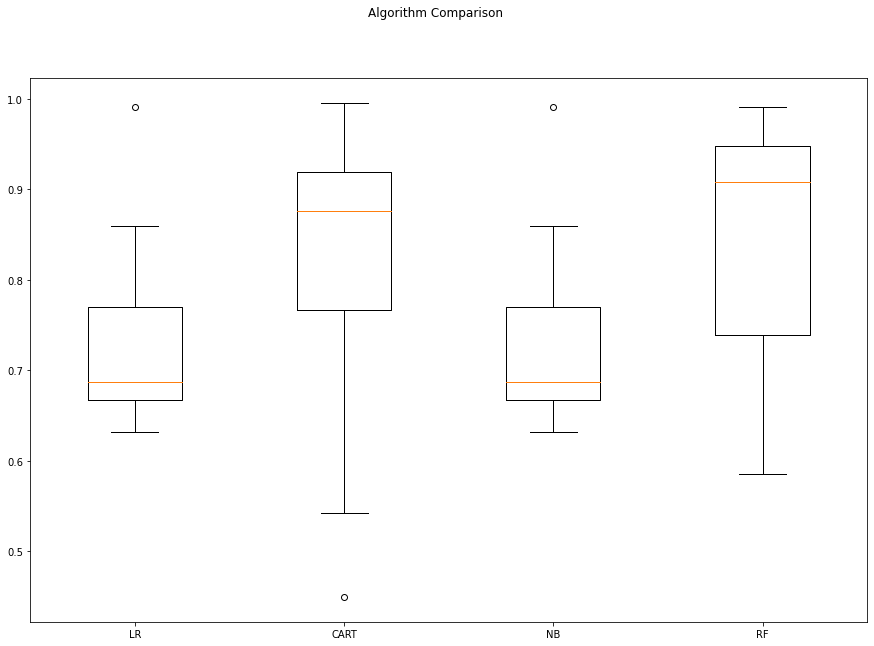

In [37]:
%%time
# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression()))
#models.append(('LDA', LinearDiscriminantAnalysis()))
#models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
#models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
times = []
scoring = 'accuracy'
for name, model in models:
    s = time.time()
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, x, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    
    model.fit(x_train, y_train)
    predictions = model.predict(x_validation)
    print('accuracy score: ', accuracy_score(y_validation, predictions))
    print("F1->", confusion_matrix(y_validation, predictions))
    print("Extended-> ", classification_report(y_validation, predictions))
    e = time.time()
    print(msg)
    times.append(e - s)
    print('time: ',e - s)
    s = 0
    e = 0
# boxplot algorithm comparison
fig = plt.figure(figsize=(15,10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
#plt.savefig('classification1m.jpg')
#plt.show()